#### ignore warnings

In [2]:
import warnings;
warnings.filterwarnings('ignore')

In [4]:
import os
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Dense
from keras.layers import LSTM
#from keras.layers.recurrent import LSTM
import keras.backend as K
from IPython.display import Audio
from pipes import quote

#### show libary versions

In [5]:
import keras as k
import numpy as np
import sys
import tensorflow as tf

# print python verion
print(sys.version)
print("TensorFlow:", tf.__version__)
print("Keras:", k.__version__)
print("Numpy:", np.__version__)

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
TensorFlow: 1.13.1
Keras: 2.2.4
Numpy: 1.16.4


In [5]:
def read_wav_as_np(file):
    # wav.read returns the sampling rate per second  (as an int) and the data (as a numpy array)
    data = wav.read(file)
    # Normalize 16-bit input to [-1, 1] range
    np_arr = data[1].astype('float32') / 32767.0
    #np_arr = np.array(np_arr)
    return np_arr, data[0]

def write_np_as_wav(X, sample_rate, file):
    # Converting the tensor back to it's original form
    Xnew = X * 32767.0
    Xnew = Xnew.astype('int16')
    # wav.write constructs the .wav file using the specified sample_rate and tensor
    wav.write(file, sample_rate, Xnew)
    return

def convert_sample_blocks_to_np_audio(blocks):
    # Flattens the blocks into a single list
    song_np = np.concatenate(blocks)
    return song_np

def convert_np_audio_to_sample_blocks(song_np, block_size):
    # Block lists initialised
    block_lists = []
    # total_samples holds the size of the numpy array
    total_samples = song_np.shape[0]
    # print('total_samples=',total_samples)

    # num_samples_so_far is used to loop through the numpy array
    num_samples_so_far = 0

    while (num_samples_so_far < total_samples):

        # Stores each block in the "block" variable
        block = song_np[num_samples_so_far:num_samples_so_far + block_size]

        if (block.shape[0] < block_size):
            # this is to add 0's in the last block if it not completely filled
            padding = np.zeros((block_size - block.shape[0],))
            # block_size is 44100 which is fixed throughout whereas block.shape[0] for the last block is <=44100
            block = np.concatenate((block,padding))
        block_lists.append(block)
        num_samples_so_far += block_size
    return block_lists

In [6]:
def time_blocks_to_fft_blocks(blocks_time_domain):
    # FFT blocks initialized
    fft_blocks = []
    for block in blocks_time_domain:
        # Computes the one-dimensional discrete Fourier Transform and returns the complex nD array
        # i.e The truncated or zero-padded input, transformed from time domain to frequency domain.
        fft_block = np.fft.fft(block)
        # Joins a sequence of blocks along frequency axis.
        new_block = np.concatenate((np.real(fft_block), np.imag(fft_block)))
        fft_blocks.append(new_block)
    return fft_blocks

def fft_blocks_to_time_blocks(blocks_ft_domain):
    # Time blocks initialized
    time_blocks = []
    for block in blocks_ft_domain:
        # add type int
        num_elems = int(block.shape[0] / 2)
        # Extracts real part of the amplitude corresponding to the frequency
        real_chunk = block[0:num_elems]
        # Extracts imaginary part of the amplitude corresponding to the frequency
        imag_chunk = block[num_elems:]
        # Represents amplitude as a complex number corresponding to the frequency
        new_block = real_chunk + 1.0j * imag_chunk
        # Computes the one-dimensional discrete inverse Fourier Transform and returns the transformed
        # block from frequency domain to time domain
        time_block = np.fft.ifft(new_block)
        # Joins a sequence of blocks along time axis.
        time_blocks.append(time_block)
    return time_blocks

In [7]:
import os
cwd = os.getcwd()


In [8]:
sample_frequency = 44100
block_size = 44100
filename = cwd + '/datasets/training_data/Happy.mp3'


In [9]:
files = filename.split('/')
orig_filename = files[-1][0:-4]
if (filename[0] == '/'):
    new_path = '/'
for i in range(len(files) - 1):
    new_path += files[i] + '/'
# We define the file names for the newly created WAV files and the Mono mp3 file
filename_tmp = new_path + orig_filename + 'Mono.mp3'
new_name = new_path + orig_filename + '.wav'

# These lines calls LAME to resample the audio file at the standard analog frequency of 44,100 Hz and then convert it to WAV
sample_freq_str = "{0:.1f}".format(float(sample_frequency) / 1000.0)
cmd = 'lame -a -m m {0} {1}'.format(quote(filename), quote(filename_tmp))
os.system(cmd)
cmd = 'lame --decode {0} {1} --resample {2}'.format(quote(filename_tmp), quote(new_name), sample_freq_str)
os.system(cmd)

0

In [10]:
bitrate, data = wav.read(new_name)
# wav_array contains normalized data
wav_array, bitrate = read_wav_as_np(new_name)
# wav_array is converted into blocks with zeroes padded to fill the empty space in last block if any
wav_blocks_zero_padded = convert_np_audio_to_sample_blocks(wav_array, block_size)


In [11]:
# Flattens the blocks into an array
wav_array_zero_padded = convert_sample_blocks_to_np_audio(wav_blocks_zero_padded)


In [12]:
shifted_wav_blocks_zero_padded = wav_blocks_zero_padded[1:]
shifted_wav_array_zero_padded = convert_sample_blocks_to_np_audio(shifted_wav_blocks_zero_padded)


In [13]:
X = time_blocks_to_fft_blocks(wav_blocks_zero_padded)
Y = time_blocks_to_fft_blocks(shifted_wav_blocks_zero_padded)
X_flat = np.concatenate(X)
Y_flat = np.concatenate(Y)

In [14]:
cur_seq = 0
chunks_X = []
chunks_Y = []
#max_seq_len = 10
max_seq_len = 10
total_seq = len(X)
while cur_seq + max_seq_len < total_seq:
    chunks_X.append(X[cur_seq:cur_seq + max_seq_len])
    chunks_Y.append(Y[cur_seq:cur_seq + max_seq_len])
    cur_seq += max_seq_len
# Number of examples
num_examples = len(chunks_X) 
# Imaginary part requires the extra space
num_dims_out = block_size * 2
# Dimensions of the training dataset
out_shape = (num_examples, max_seq_len, num_dims_out)
x_data = np.zeros(out_shape)
y_data = np.zeros(out_shape)
# Populating the training dataset
for n in range(num_examples):
    for i in range(max_seq_len):
        x_data[n][i] = chunks_X[n][i]
        y_data[n][i] = chunks_Y[n][i]

In [15]:
num_frequency_dimensions = (np.shape(X))[1]
num_hidden_dimensions = 1024

#### LSTM

In [20]:
num_hidden_dimensions = 1024
num_frequency_dimensions = 88200
num_recurrent_units = 1

activation = 'relu'
#activation='tanh'

stateful = False

model = Sequential()
# This layer converts frequency space to hidden space
model.add(
    TimeDistributed(Dense(num_hidden_dimensions, activation=activation),
                    input_shape=(None, num_frequency_dimensions)))

# model.add(TimeDistributedDense(input_dim=num_frequency_dimensions, output_dim=num_hidden_dimensions))
for cur_unit in range(num_recurrent_units):
    model.add(
        LSTM(num_hidden_dimensions, return_sequences=True, stateful=stateful))

# This layer converts hidden space back to frequency space
model.add(
    TimeDistributed(
        Dense(input_dim=num_hidden_dimensions,
              output_dim=num_frequency_dimensions,
              activation=activation)))

#model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.compile(optimizer='adam', loss='mean_squared_error')

#### Train LSTM model

Iteration: 0
Train on 8 samples, validate on 5 samples
Epoch 1/1
8/8 [==============================] - 9s 1s/step - loss: 1175.6430 - acc: 0.0875 - val_loss: 1346.7555 - val_acc: 0.0400
Iteration: 1
Train on 8 samples, validate on 5 samples
Epoch 1/1
8/8 [==============================] - 9s 1s/step - loss: 1174.7208 - acc: 0.0875 - val_loss: 1345.7659 - val_acc: 0.0400
Iteration: 2
Train on 8 samples, validate on 5 samples
Epoch 1/1
8/8 [==============================] - 8s 968ms/step - loss: 1173.8695 - acc: 0.0875 - val_loss: 1344.7771 - val_acc: 0.0400
Iteration: 3
Train on 8 samples, validate on 5 samples
Epoch 1/1
8/8 [==============================] - 9s 1s/step - loss: 1173.0374 - acc: 0.0875 - val_loss: 1343.8115 - val_acc: 0.0400
Iteration: 4
Train on 8 samples, validate on 5 samples
Epoch 1/1
8/8 [==============================] - 10s 1s/step - loss: 1172.2191 - acc: 0.0875 - val_loss: 1342.9137 - val_acc: 0.0400
Iteration: 5
Train on 8 samples, validate on 5 samples
Epoch 

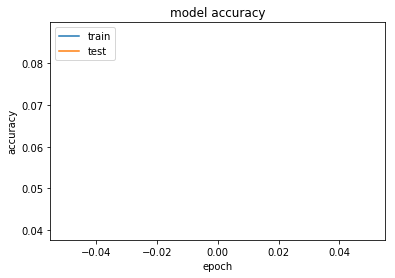

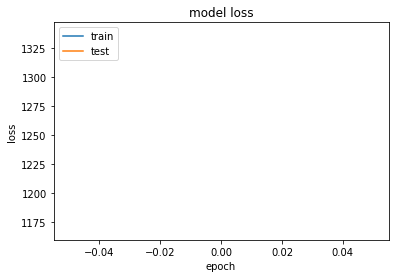

Training complete!


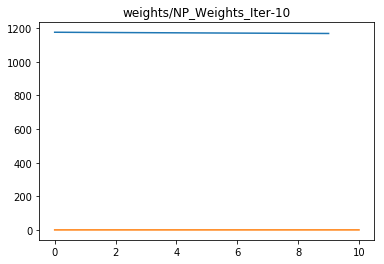

In [48]:
loss = []
acc = []
# Number of iterations for training
num_iters = 10
# Number of iterations before we save our model
epochs_per_iter = 1
# Number of training examples pushed to the GPU per batch.
batch_size = 5
# Path to weights file
weights_path = 'weights/NP_Weights_Iter-' + str(num_iters)
cur_iter = 0

while cur_iter < num_iters:
    print('Iteration: ' + str(cur_iter))
    # Iterate over the training data in batches
    history = model.fit(x_data,
                        y_data,
                        batch_size=batch_size,
                        epochs=epochs_per_iter,
                        verbose=1,
                        validation_split=0.33)
    loss += history.history['loss']
    acc +=  history.history['acc']
    
    cur_iter += 1
print(history.history.keys())        
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


print('Training complete!')
model.save_weights(weights_path)

plt.plot(range(len(loss)), loss)
plt.plot(range(len(acc)), acc)
plt.title(weights_path)
plt.savefig(str(weights_path) + ".png")

In [51]:
history = model.fit(, Y, validation_split=0.33, epochs=15, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())

SyntaxError: invalid syntax (<ipython-input-51-92c740eb2fb6>, line 1)

In [53]:
history = model.fit(x_data, y_data, validation_split=0.33, epochs=10, batch_size=10, verbose=1)
print(history.history.keys())


Train on 8 samples, validate on 5 samples
Epoch 1/10
8/8 [==============================] - 9s 1s/step - loss: 1131.1646 - acc: 0.1250 - val_loss: 1296.9631 - val_acc: 0.0800
Epoch 2/10
8/8 [==============================] - 10s 1s/step - loss: 1130.9954 - acc: 0.1250 - val_loss: 1296.7571 - val_acc: 0.0800
Epoch 3/10
8/8 [==============================] - 10s 1s/step - loss: 1130.8196 - acc: 0.1250 - val_loss: 1296.5471 - val_acc: 0.0800
Epoch 4/10
8/8 [==============================] - 8s 945ms/step - loss: 1130.6283 - acc: 0.1375 - val_loss: 1296.3407 - val_acc: 0.0800
Epoch 5/10
8/8 [==============================] - 6s 793ms/step - loss: 1130.4470 - acc: 0.1375 - val_loss: 1296.1387 - val_acc: 0.0800
Epoch 6/10
8/8 [==============================] - 8s 999ms/step - loss: 1130.2632 - acc: 0.1375 - val_loss: 1295.9281 - val_acc: 0.0800
Epoch 7/10
8/8 [==============================] - 7s 928ms/step - loss: 1130.0808 - acc: 0.1375 - val_loss: 1295.7297 - val_acc: 0.1000
Epoch 8/10
8/

In [40]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc'])

In [42]:
acc = history.history['acc']
history = model.fit(, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)


print(acc)

[0.0]


In [34]:
from __future__ import absolute_import
from __future__ import print_function
import argparse
import os
from matplotlib import pyplot as plt
import numpy as np
import nn_utils.network_utils as network_utils
import config.nn_config as nn_config
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

CONFIG = nn_config.get_neural_net_configuration()
INPUTFILE = CONFIG['model_file']
CUR_ITER = 0
MODEL_BASENAME = CONFIG['model_basename']
MODEL_FILENAME = MODEL_BASENAME + str(CUR_ITER)

# Load up the training data
print('Loading training data')
# X_train is a tensor of size (num_train_examples, num_timesteps, num_frequency_dims)
# y_train is a tensor of size (num_train_examples, num_timesteps, num_frequency_dims)
X_TRAIN = np.load(INPUTFILE + '_x.npy')
Y_TRAIN = np.load(INPUTFILE + '_y.npy')
print('Finished loading training data')

# Figure out how many frequencies we have in the data
FREQ_SPACE_DIMS = X_TRAIN.shape[2]  #88FREQ_SPACE_DIMS200
HIDDEN_DIMS = CONFIG['hidden_dimension_size']
NUM_RECURR = 1
NUM_ITERS = 1
EPOCHS_PER_ITER = 3
BATCH_SIZE = 5

# Creates a lstm network
MODEL = network_utils.create_lstm_network(
    FREQ_SPACE_DIMS=FREQ_SPACE_DIMS,
    NUM_HIDDEN_DIMENSIONS=HIDDEN_DIMS,
    NUM_RECURRENT_UNITS=NUM_RECURR)

# Load existing weights if available
if os.path.isfile(MODEL_FILENAME):
    MODEL.load_weights(MODEL_FILENAME)

# Larger batch sizes require more memory, but training will be faster
print('Starting training!')
weights_path = 'weights/LSTM_NP_Weights_Iter-' + str(NUM_ITERS)
weights_name = 'LSTM_NP_Weights_Iter-' + str(NUM_ITERS)

LOSS = []

while CUR_ITER < NUM_ITERS:
    print('Iteration: ' + str(CUR_ITER))
    #HISTORY = MODEL.fit(X_TRAIN, Y_TRAIN, batch_size=BATCH_SIZE, epochs=EPOCHS_PER_ITER, verbose=1)
    HISTORY = MODEL.fit(X_TRAIN,
                        Y_TRAIN,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS_PER_ITER,
                        verbose=1,
                        validation_split=0.0,
                        callbacks=[plot_losses])
    #loss_list += history.history['loss']

    LOSS += HISTORY.history['loss']b
    with open('lstm_losslist.txt', 'a') as filehandle:
        for listitem in LOSS:
            filehandle.write('%s\n' % listitem)
    CUR_ITER += 1

print('Training complete!')
MODEL.save_weights(weights_path + ".h5")
p1 = plt.plot(range(len(LOSS)), LOSS)
plt.title(weights_name)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.savefig(str(weights_path) + ".png")

Loading training data
Finished loading training data
Starting training!
Iteration: 0


NameError: name 'plot_losses' is not defined

In [26]:
MODEL_FILENAME = MODEL_BASENAME + str(CUR_ITER)
MODEL_FILENAME 

'weights/np_weights_iter-1'

In [36]:
history_dict = hostory.history
history_dict.keys()

NameError: name 'HISTORY' is not defined

In [29]:
!ls weights/

GRU_NP_Weights_Iter-10     NP_Weights_Iter-1
GRU_NP_Weights_Iter-10.png NP_Weights_Iter-1.h5
GRU_NP_Weights_Iter-20     NP_Weights_Iter-1.png
GRU_NP_Weights_Iter-20.png NP_Weights_Iter-2.h5
GRU_NP_Weights_Iter-5.h5   NP_Weights_Iter-2.png
GRU_NP_Weights_Iter-5.png  NP_Weights_Iter-5.h5
LSTM_NP_Weights_Iter-1.h5  NP_Weights_Iter-5.png
LSTM_NP_Weights_Iter-1.png


#### LSTM

In [31]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [20]:
model.reset_states() 


NameError: name 'layer' is not defined

In [29]:
num_hidden_dimensions = 1024
num_frequency_dimensions = 88200
num_recurrent_units = 1
activation = 'relu'
stateful = False

import pydot_ng as pydot
from keras.layers import LSTM

from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
model = Sequential()
# This layer converts frequency space to hidden space
model.add(
    TimeDistributed(Dense(num_hidden_dimensions, activation=activation),
                    input_shape=(None, num_frequency_dimensions)))

# model.add(TimeDistributedDense(input_dim=num_frequency_dimensions, output_dim=num_hidden_dimensions))
for cur_unit in range(num_recurrent_units):
    model.add(
        LSTM(num_hidden_dimensions, return_sequences=True, stateful=stateful))

# This layer converts hidden space back to frequency space
model.add(
    TimeDistributed(
        Dense(input_dim=num_hidden_dimensions,
              output_dim=num_frequency_dimensions,
              activation=activation)))

#model.compile(loss='mean_squared_error', optimizer='rmsprop')
#print "Compiling..."
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
plot_model(model,
           to_file='lstm_model_plot.png',
           show_shapes=True,
           show_layer_names=True)

In [31]:
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, None, 1024)        90317824  
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 1024)        8392704   
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 88200)       90405000  
Total params: 189,115,528
Trainable params: 189,115,528
Non-trainable params: 0
_________________________________________________________________
None


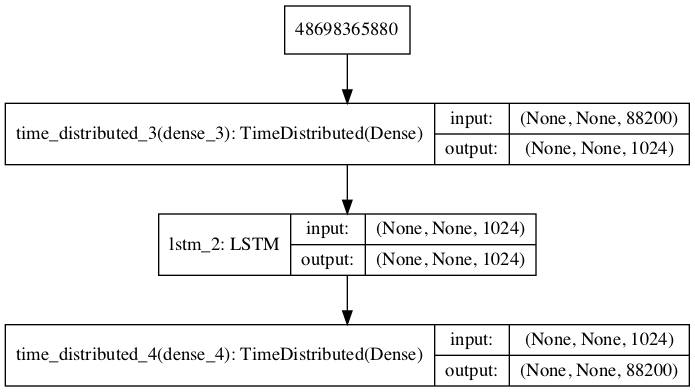

In [22]:
# Display picture
from IPython.display import Image
Image(filename='lstm_model_plot.png') 

Iteration: 0
Epoch 1/5
13/13 [==============================] - 30s 2s/step - loss: 1254.7895
Epoch 2/5
13/13 [==============================] - 9s 724ms/step - loss: 1249.1708
Epoch 3/5
13/13 [==============================] - 10s 747ms/step - loss: 1243.0538
Epoch 4/5
13/13 [==============================] - 10s 747ms/step - loss: 1237.7432
Epoch 5/5
13/13 [==============================] - 10s 767ms/step - loss: 1233.0587
Iteration: 1
Epoch 1/5
13/13 [==============================] - 10s 766ms/step - loss: 1228.9005
Epoch 2/5
13/13 [==============================] - 8s 644ms/step - loss: 1225.1946
Epoch 3/5
13/13 [==============================] - 8s 647ms/step - loss: 1221.5099
Epoch 4/5
13/13 [==============================] - 9s 679ms/step - loss: 1218.0061
Epoch 5/5
13/13 [==============================] - 9s 699ms/step - loss: 1214.7372
Iteration: 2
Epoch 1/5
13/13 [==============================] - 10s 748ms/step - loss: 1211.2935
Epoch 2/5
13/13 [============================

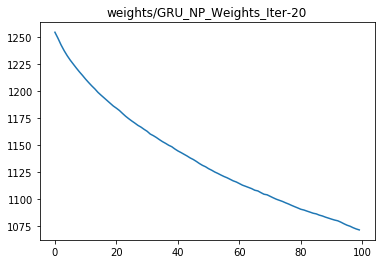

In [49]:
import pydot_ng as pydot
from keras.layers import GRU

from keras.layers import TimeDistributed
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

model = Sequential()
# This layer converts frequency space to hidden space
model.add(
    TimeDistributed(Dense(num_hidden_dimensions),
                    input_shape=(None, num_frequency_dimensions)))
model.add(GRU(units=num_hidden_dimensions, return_sequences=True))
# This layer converts hidden space back to frequency space
model.add(TimeDistributed(Dense(num_frequency_dimensions)))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
plot_model(model,
           to_file='gru_model_plot.png',
           show_shapes=True,
           show_layer_names=True)

loss = []
# Number of iterations for training
num_iters = 20
# Number of iterations before we save our model
epochs_per_iter = 5
# Number of training examples pushed to the GPU per batch.
batch_size = 5

# Path to weights file
weights_path = 'weights/GRU_NP_Weights_Iter-' + str(num_iters)
weights_name = 'GRU_NP_Weights_Iter-' + str(NUM_ITERS)

cur_iter = 0

while cur_iter < num_iters:

    print('Iteration: ' + str(cur_iter))
    # Iterate over the training data in batches
    history = model.fit(x_data,
                        y_data,
                        batch_size=batch_size,
                        epochs=epochs_per_iter,
                        verbose=1,
                        validation_split=0.0)
    loss += history.history['loss']
    cur_iter += 1
print('Training complete!')
model.save_weights(weights_path)

p1 = plt.plot(range(len(loss)), loss)
plt.title(weights_name)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.savefig(str(weights_path) + ".png")

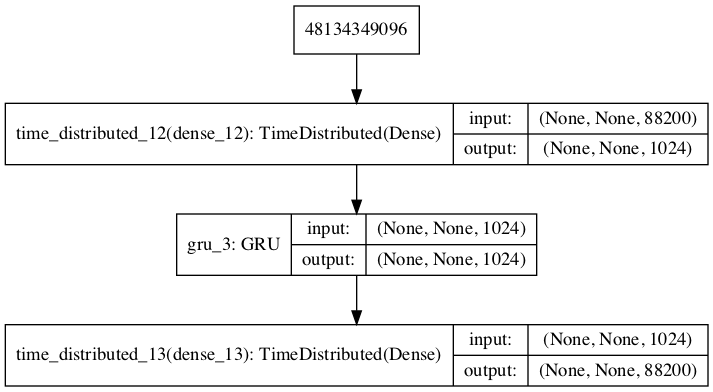

In [46]:
# Display picture
from IPython.display import Image
Image(filename='gru_model_plot.png') 

In [ ]:
def create_gru_network(num_frequency_dimensions, num_hidden_dimensions):

Iteration: 0
Epoch 1/1
13/13 [==============================] - 18s 1s/step - loss: 1255.0552
Training complete!


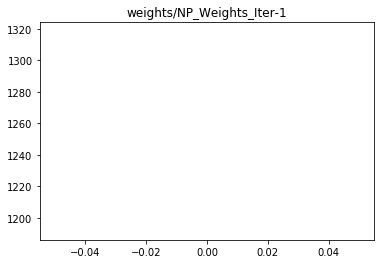

In [47]:
loss = []
# Number of iterations for training
num_iters = 1
# Number of iterations before we save our model
epochs_per_iter = 1
# Number of training examples pushed to the GPU per batch.
batch_size = 5

# Path to weights file
weights_path = 'weights/GRU_NP_Weights_Iter-' + str(num_iters)
cur_iter = 0

while cur_iter < num_iters:

    print('Iteration: ' + str(cur_iter))
    # Iterate over the training data in batches
    history = model.fit(x_data,
                        y_data,
                        batch_size=batch_size,
                        epochs=epochs_per_iter,
                        verbose=1,
                        validation_split=0.0)
    loss += history.history['loss']
    cur_iter += 1
print('Training complete!')
model.save_weights(weights_path)

p1 = plt.plot(range(len(loss)), loss)
plt.title(weights_path)
plt.savefig(str(weights_path) + ".png")

In [50]:
# We take the first chunk of the training data itself for seed sequence.
seed_seq = x_data[0]
# Reshaping the sequence to feed to the RNN.
seed_seq = np.reshape(seed_seq, (1, seed_seq.shape[0], seed_seq.shape[1]))
# Generated song sequence is stored in output.
output = []
for it in range(max_seq_len):
    # Generates new value
    seedSeqNew = model.predict(seed_seq)
    # Appends it to the output
    if it == 0:
        for i in range(seedSeqNew.shape[1]):
            output.append(seedSeqNew[0][i].copy())
    else:
        output.append(seedSeqNew[0][seedSeqNew.shape[1] - 1].copy())
    # newSeq contains the generated sequence.
    newSeq = seedSeqNew[0][seedSeqNew.shape[1] - 1]
    # Reshaping the new sequence for concatenation.
    newSeq = np.reshape(newSeq, (1, 1, newSeq.shape[0]))
    # Appending the new sequence to the old sequence.
    seed_seq = np.concatenate((seed_seq, newSeq[:, 1:, :]), axis=1)

In [52]:
gen_song_nr = []
gen_song_nr = 0

In [53]:
# The path for the generated song
gen_song_nr += 1
song_path = 'generated_song_' +str(gen_song_nr) + ".wav"
# Reversing the conversions
time_blocks = fft_blocks_to_time_blocks(output)
song = convert_sample_blocks_to_np_audio(time_blocks)
write_np_as_wav(song, sample_frequency, song_path)

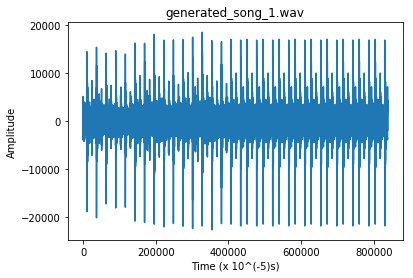

In [55]:
%matplotlib inline
bitrate, data = wav.read(song_path)
plt.plot(data)
plt.title(song_path)
plt.xlabel("Time (x 10^(-5)s)")
plt.ylabel("Amplitude")
plt.show()
Audio(song_path)
#None

In [59]:
MODEL_WEIGTHS 

In [102]:
from __future__ import absolute_import
from __future__ import print_function
import glob
import re
import os
import numpy as np
import inquirer
import nn_utils.network_utils as network_utils
import gen_utils.seed_generator as seed_generator
import gen_utils.sequence_generator as sequence_generator
from gen_utils.filename_generator import saveSong
from data_utils.parse_files import save_generated_example
import config.nn_config as nn_config

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
CONFIG = nn_config.get_neural_net_configuration()

# Select  weights file for generating song
MODEL_WEIGTHS = [
    inquirer.List('size',
                  message="Please choose saved weights file for generating the song",
                  choices=glob.glob('weights/*.h5')
                  ),
]

CHOOSE_MODEL = inquirer.prompt(MODEL_WEIGTHS)

SAMPLE_FREQUENCY = CONFIG['sampling_frequency']

INPUTFILE = CONFIG['model_file']
MODEL_BASENAME = CONFIG['model_basename']
CUR_ITER = 10

MODEL_FILENAME = CHOOSE_MODEL["size"]

print("sample_frequency:", SAMPLE_FREQUENCY)
print("INPUTFILE:", INPUTFILE)
print("MODEL_BASENAME:", MODEL_BASENAME)
print("cur_iter:", CUR_ITER)
print("model_filename:", MODEL_FILENAME)


OUTPUT_FILENAME = saveSong()


# Load up the training data
print('Loading training data')
# X_train is a tensor of size (num_train_examples, num_timesteps, num_frequency_dims)
# y_train is a tensor of size (num_train_examples, num_timesteps, num_frequency_dims)
# X_mean is a matrix of size (num_frequency_dims,) containing the mean for each frequency dimension
# X_var is a matrix of size (num_frequency_dims,)
# containing the variance for each frequency dimension
X_TRAIN = np.load(INPUTFILE + '_x.npy')
Y_TRAIN = np.load(INPUTFILE + '_y.npy')
X_MEAN = np.load(INPUTFILE + '_mean.npy')
X_VAR = np.load(INPUTFILE + '_var.npy')
print('Finished loading training data')

# Figure out how many frequencies we have in the data

FREQ_SPACE_DIMS = X_TRAIN.shape[2]
HIDDEN_DIMS = CONFIG['hidden_dimension_size']

# Creates a lstm network
MODEL = network_utils.create_lstm_network(num_frequency_dimensions=FREQ_SPACE_DIMS,
                                          NUM_HIDDEN_DIMENSIONS=HIDDEN_DIMS, NUM_RECURRENT_UNITS=1)


MODEL = network_utils.create_gru_network(num_frequency_dimensions=FREQ_SPACE_DIMS,
                                          NUM_HIDDEN_DIMENSIONS=HIDDEN_DIMS)

# Load existing weights if available
if os.path.exists(MODEL_FILENAME):
    MODEL.load_weights(MODEL_FILENAME)
else:
    print('Model filename ' + MODEL_FILENAME + ' could not be found!')

def show_values():
    for k, v in CONFIG.items():
        print(k + ': ' + str(v))

show_values()
print('Starting generation!')

SEED_LEN = 1
SEED_SEQ = seed_generator.generate_copy_seed_sequence(seed_length=SEED_LEN,
                                                      training_data=X_TRAIN)

# Defines final song length. Total song length in samples = max_seq_len * example_len
MAX_SEQ_LEN = 10

OUTPUT = sequence_generator.generate_from_seed(model=MODEL, seed=SEED_SEQ,
                                               data_variance=X_VAR, data_mean=X_MEAN, sequence_length=MAX_SEQ_LEN)

print('Finished generation!')

# Save the generated sequence to a WAV file
save_generated_example(str(OUTPUT_FILENAME), OUTPUT, sample_frequency=SAMPLE_FREQUENCY)



[?] Please choose saved weights file for generating the song: weights/NP_Weights_Iter-2.h5
 > weights/NP_Weights_Iter-2.h5
   weights/NP_Weights_Iter-5.h5
   weights/NP_Weights_Iter-1.h5
   weights/GRU_NP_Weights_Iter-5.h5



error: (25, 'Inappropriate ioctl for device')

In [ ]:
model = Sequential()
# This layer converts frequency space to hidden space
model.add(TimeDistributed(Dense(num_hidden_dimensions), input_shape=(None, num_frequency_dimensions)))
model.add(GRU(units=num_hidden_dimensions, return_sequences=True))
# This layer converts hidden space back to frequency space
model.add(TimeDistributed(Dense(num_frequency_dimensions)))
model.compile(loss='mean_squared_error', optimizer='rmsprop')

In [ ]:
model = Sequential()
# This layer converts frequency space to hidden space
model.add(
    TimeDistributed(Dense(num_hidden_dimensions, activation=l_activation),
                    input_shape=(None, num_frequency_dimensions)))

# model.add(TimeDistributedDense(input_dim=num_frequency_dimensions, output_dim=num_hidden_dimensions))
for cur_unit in range(num_recurrent_units):
    model.add(
        LSTM(num_hidden_dimensions, return_sequences=True, stateful=stateful))

# This layer converts hidden space back to frequency space
model.add(
    TimeDistributed(
        Dense(input_dim=num_hidden_dimensions,
              output_dim=num_frequency_dimensions,
              activation=l_activation)))

#model.compile(loss='mean_squared_error', optimizer='rmsprop')
#print "Compiling..."
model.compile(optimizer='adam', loss='mean_squared_error')
plot_model(model,
           to_file='lstm_model_plot.png',
           show_shapes=True,
           show_layer_names=True)

In [ ]:
tf.keras.layers.Dense

In [73]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(num_hidden_dimensions,
                                  activation=tf.keras.activations.relu,
                                  input_shape=(None, ))),
        keras.layers.LSTM(num_hidden_dimensions,
                          return_sequences=True,
                          stateful=stateful),
        tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(num_hidden_dimensions,
                                  activation=tf.keras.activations.softmax))
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])

    return model

In [74]:
create_model()

In [65]:
def create_model():
    model = tf.keras.models.Sequential([
        keras.layers.Dense(512,
                           activation=tf.keras.activations.relu,
                           input_shape=(784, )),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation=tf.keras.activations.softmax)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])

    return model

In [ ]:
    history = model.fit(x_data, y_data, batch_size=batch_size, epochs=epochs_per_iter, verbose=1, validation_split=0.0)



In [77]:
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    verbose=1,
    save_weights_only=True,
    # Save weights, every 5-epochs.
    period=5)

model = create_model()
model.save_weights(checkpoint_path.format(epoch=0))
model.fit(
    x_data,
    y_data,
    epochs=50,
    callbacks=[cp_callback],
    #validation_data = (test_images,test_labels),
    verbose=0)


Consider using a TensorFlow optimizer from `tf.train`.


InvalidArgumentError: Can not squeeze dim[2], expected a dimension of 1, got 88200
	 [[{{node metrics_2/acc/Squeeze}}]]

In [66]:
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    verbose=1,
    save_weights_only=True,
    # Save weights, every 5-epochs.
    period=5)

model = create_model()
model.save_weights(checkpoint_path.format(epoch=0))
model.fit(train_images,
          train_labels,
          epochs=50,
          callbacks=[cp_callback],
          validation_data=(test_images, test_labels),
          verbose=0)


Consider using a TensorFlow optimizer from `tf.train`.


NameError: name 'train_images' is not defined

In [70]:
glob.glob('weights/GRU*.h5')

['weights/GRU_NP_Weights_Iter-5.h5']

In [41]:
!ls 

Music_Generation.ipynb    generate.py               nn_utils
README.md                 generate_gru.py           regression_model_plot.png
check_system_setup.py     generated_song_1.wav      report.txt
config                    gru_losslist.txt          requirements.txt
convert_directory.py      gru_model_plot.png        train.py
create_dir.py             img                       train_gru.py
data_utils                losslist.txt              troubleshooting
datasets                  lstm_losslist.txt         updated_train.py
gen_songs                 lstm_model_plot.png       weights
gen_utils                 newlstm_model_plot.png


In [44]:
loss, acc = new_model.evaluate(test_images, test_labels)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

NameError: name 'new_model' is not defined

In [43]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
from tensorflow import keras

tf.__version__
# Recreate the exact same model, including weights and optimizer.
new_model = keras.models.load_model('weights/LSTM_NP_Weights_Iter-5.h5')
#new_model.summary()

ValueError: No model found in config file.

In [54]:
# Visualize training history
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load pima indians dataset
dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]
# create model
model = Sequential()
model.add(Dense(12, input_dim=8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

OSError: pima-indians-diabetes.csv not found.